In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import scipy
#import matplotlib.colors
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from epi.models import Parameter, Model
from epi.normalizing_flows import NormalizingFlow
from epi.util import pairplot, AugLagHPs
from epi.example_eps import V1_dr_eps, V1_all_dr_eps
import os
from epi.util import pairplot

neuron_inds = {'E':0, 'P':1, 'S':2, 'V':3}

In [2]:
inc_val = 0.0

D = 4
lb = -5.*np.ones((D,))
ub = 5.*np.ones((D,))

dh = Parameter("dh", D, lb=lb, ub=ub)
parameters = [dh]

alphas = ['E', 'P', 'S', 'V']
num_alphas = len(alphas)

black = np.array([0, 0, 0])
blue = '#4769A0'
red = '#AF3A31'
green = '#287C5A'
colors = [black, blue, red, green]

In [3]:
purple = '#4C0099'

def plot_T_x(T_x, T_x_sim, bins=30, xmin=None, xmax=None, xlabel=None, ylim=None, fontsize=14):
    if xmin is not None and xmax is not None:
        _range = (xmin, xmax)
    else:
        _range = None
    plt.figure()
    if T_x is None:
        plt.hist(T_x_sim, bins=bins, range=_range, color=purple, alpha=0.5)
    else:
        n, bins, patches = plt.hist(T_x, bins=bins, color='k', range=_range, alpha=0.5)
        plt.hist(T_x_sim, bins=bins, color=purple, alpha=0.5)
    if ylim is not None:
        plt.ylim(ylim)
    if xlabel is not None:
        plt.xlabel(xlabel, fontsize=fontsize)
    plt.ylabel('count', fontsize=fontsize)
    return None

V1_Circuit_P_eps=0.40
['data/epi/V1_Circuit_P_eps=0.40/a2c18082e7d1e33948198182605af211/D4_C3_L2_U50_bnmom=9.99E-01_PA_rs1/16570bfe968f87c60220c42381c6e268/N500_lr1.00E-03_c0=1.00E-02_gamma2.50E-01_beta2.00E+00', 'data/epi/V1_Circuit_P_eps=0.40/a2c18082e7d1e33948198182605af211/D4_C3_L2_U50_bnmom=9.99E-01_PA_rs2/16570bfe968f87c60220c42381c6e268/N500_lr1.00E-03_c0=1.00E-02_gamma2.50E-01_beta2.00E+00', 'data/epi/V1_Circuit_P_eps=0.40/a2c18082e7d1e33948198182605af211/D4_C3_L2_U50_bnmom=9.99E-01_PA_rs3/16570bfe968f87c60220c42381c6e268/N500_lr1.00E-03_c0=1.00E-02_gamma2.50E-01_beta2.00E+00', 'data/epi/V1_Circuit_P_eps=0.40/a2c18082e7d1e33948198182605af211/D4_C3_L2_U50_bnmom=9.99E-01_PA_rs4/16570bfe968f87c60220c42381c6e268/N500_lr1.00E-03_c0=1.00E-02_gamma2.50E-01_beta2.00E+00', 'data/epi/V1_Circuit_P_eps=0.40/a2c18082e7d1e33948198182605af211/D4_C3_L2_U50_bnmom=9.99E-01_PA_rs5/16570bfe968f87c60220c42381c6e268/N500_lr1.00E-03_c0=1.00E-02_gamma2.50E-01_beta2.00E+00']
0.95_0.03
0.93_0.01
0.86_0.

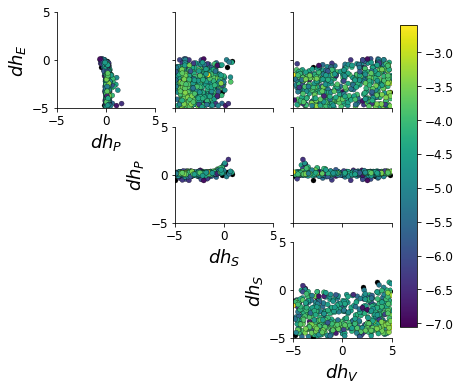

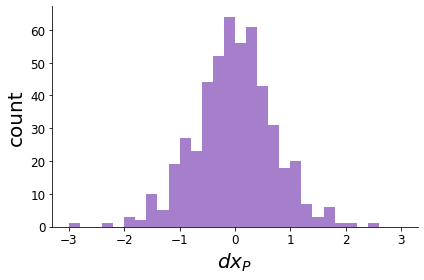

In [15]:
M = 500
s = 25

# Define model
alphas = ['P']
sigma_epss = [0.4]

figdir = "/Users/seanbittner/Documents/epi/written/V1_model/figs/FigSX/"
npzfile = np.load("SVflip_hs.npz")
h = npzfile['b_cross'][0]
mu = np.array([0., 0.5**2])

nus = {'E':0.125, 'P':0.25, 'S':0.25, 'V':0.25}

for alpha in alphas:
    nu = nus[alpha]
    nu = 0.05
    for sigma_eps in sigma_epss:
        name = "V1_Circuit_%s_eps=%.2f" % (alpha, sigma_eps)
        print(name)
        dh = Parameter("dh", D, lb=lb, ub=ub)
        parameters = [dh]
        model = Model(name, parameters)
        # Define eps
        dr = V1_dr_eps(alpha, inc_val, sigma_eps, h=h)
        model.set_eps(dr)
        
        epi_df = model.get_epi_df()
        epi_df['c0'] = [al_hps['c0'] for al_hps in epi_df['AL_hps']]
        if (alpha == 'P'):
            epi_df = epi_df[epi_df['c0'] == 1e-2]
        paths = sorted(epi_df['path'].unique())
        print(paths)
        if len(paths) == 0:
            continue
        
        best_Hs = []
        convergeds = []
        best_ks = []
        for i, path in enumerate(paths):
            if (alpha == 'E' and sigma_eps == 0.25):
                if i in [0,1,2,4]:
                    best_Hs.append(np.nan)
                    convergeds.append(False)
                    best_ks.append(0)
                    continue
            if (alpha == 'E' and sigma_eps == 0.1):
                if i in [0,1,3,4]:
                    best_Hs.append(np.nan)
                    convergeds.append(False)
                    best_ks.append(0)
                    continue
            if (alpha == 'P' and sigma_eps == 0.1):
                if i in [0,1,3,4]:
                    best_Hs.append(np.nan)
                    convergeds.append(False)
                    best_ks.append(0)
                    continue
            if (alpha == 'P' and sigma_eps == 0.25):
                if i in [1,2,3,4]:
                    best_Hs.append(np.nan)
                    convergeds.append(False)
                    best_ks.append(0)
                    continue
            epi_df2 = epi_df[epi_df['path'] == path]
            df_row = epi_df2.iloc[0]
            init = df_row['init']
            init_params = {"mu":init["mu"], "Sigma":init["Sigma"]}
            nf = model._df_row_to_nf(df_row)
            aug_lag_hps = model._df_row_to_al_hps(df_row)
            best_k, converged, best_H = model.get_convergence_epoch(init_params, nf, mu, aug_lag_hps, 
                                            alpha=0.05, nu=nu)
            best_Hs.append(best_H)
            convergeds.append(converged)
            best_ks.append(best_k)

        bestHs = np.array(best_Hs)
        best_ks = np.array(best_ks)
        
        best_Hs = np.array([x if x is not None else np.nan for x in best_Hs])
        ind = np.nanargmax(best_Hs)

        path = paths[ind]
        best_k = int(best_ks[ind])
        best_H = best_Hs[ind]
        
        print('ind', ind, path)
        print('best k', best_k)
        
        epi_df2 = epi_df[epi_df['path'] == path]
        df_row = epi_df2.iloc[0]
        init = df_row['init']
        init_params = {"mu":init["mu"], "Sigma":init["Sigma"]}
        nf = model._df_row_to_nf(df_row)
        aug_lag_hps = model._df_row_to_al_hps(df_row)

        dist = model._get_epi_dist(best_k, init_params, nf, mu, aug_lag_hps)

        z, log_q_z = dist.nf(M)
        T_x = model.eps(z).numpy()
        z = z.numpy()
        log_q_z = log_q_z.numpy()

        neurons = [alpha for alpha in neuron_inds.keys()]
        labels = [r'$dh_%s$' % alpha for alpha in neurons]
        fig, axs, = pairplot(z, range(4), labels, s=s, figsize=(6,6),
                             fontsize=18, lb=dist.nf.lb, ub=dist.nf.ub,
                             outlier_stds=3,
                             c=log_q_z, c_label='')
        plt.savefig(figdir + name + '_z.png')
        
        plot_T_x(None, T_x[:,0], xmin=-3., xmax=3., xlabel=r'$dx_%s$' % alpha, fontsize=20)
        plt.tight_layout()
        plt.savefig(figdir + name + '_Tx.png')
       
        
      
        
